# Stacking of models

https://www.kaggle.com/roydatascience/aggregating-the-light-gbm-models-0-9483
https://www.kaggle.com/paulorzp/gmean-of-light-gbm-models-lb-0-9484

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LABELS = ["isFraud"]
all_files = glob.glob("../../data/submissions/final/*.csv")
all_files

['../../data/submissions/final\\cat_09032019_1405.csv',
 '../../data/submissions/final\\kyakovlev_blend_LB_09518.csv',
 '../../data/submissions/final\\lgb_folds_umap_0818.csv',
 '../../data/submissions/final\\lgb_preds_0828.csv',
 '../../data/submissions/final\\lgb_preds_CV_09067_LB_09135.csv',
 '../../data/submissions/final\\lgb_preds_SMOTE_CV_09332_LB_08222.csv',
 '../../data/submissions/final\\logistic_preds_CV_07939_LB_08460.csv',
 '../../data/submissions/final\\logistic_preds_CV_07981_LB_08388.csv',
 '../../data/submissions/final\\logistic_preds_CV_08095_LB_08492.csv',
 '../../data/submissions/final\\stack_gmean.csv',
 '../../data/submissions/final\\tpot_08073_LB_08364.csv',
 '../../data/submissions/final\\xgb_CV_0_LB_09381.csv',
 '../../data/submissions/final\\xgb_folds_0817.csv',
 '../../data/submissions/final\\xgb_folds_CV_09275_LB_09412.csv',
 '../../data/submissions/final\\xgb_folds_umap_0819_CV_09524_LB_09023.csv',
 '../../data/submissions/final\\xgb_preds_0828.csv',
 '../..

In [3]:
outs = [pd.read_csv(f, index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)

In [4]:
concat_sub.head(5)

,TransactionID,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,m16
0,3663549,0.003421,0.004250,0.000414,0.004783,0.015887,0.237043,0.030479,0.010915,0.180105,0.000730,0.011264,0.001596,0.001092,0.000519,0.000456,0.006949,0.020560
1,3663550,0.010199,0.012226,0.001607,0.012073,0.039945,0.669638,0.030382,0.013347,0.309251,0.001877,0.011264,0.000996,0.001321,0.001739,0.000772,0.023609,0.054113
2,3663551,0.003954,0.007840,0.000434,0.006883,0.020296,0.689627,0.045898,0.022786,0.459829,0.001323,0.011264,0.003495,0.001151,0.000728,0.000965,0.012336,0.043101
3,3663552,0.002234,0.005485,0.000407,0.002405,0.013219,0.713896,0.012911,0.006882,0.158293,0.000967,0.011264,0.001524,0.001392,0.002525,0.001905,0.010131,0.019871
4,3663553,0.001890,0.010613,0.000629,0.002713,0.013038,0.373346,0.041413,0.020015,0.413821,0.001347,0.011264,0.001580,0.001411,0.002193,0.002920,0.008773,0.024597


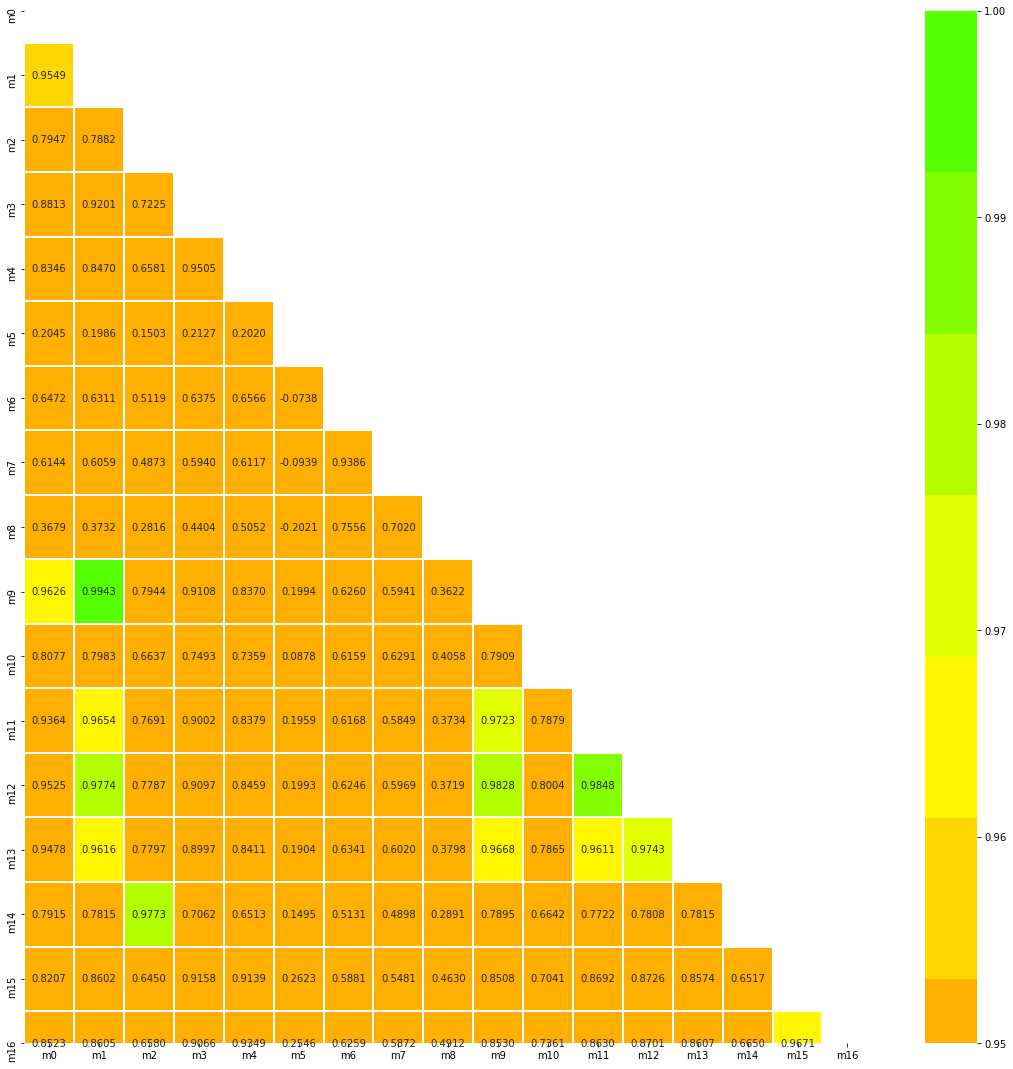

In [5]:
# check correlation
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='prism',vmin=0.95,center=0,linewidths=1,annot=True,fmt='.4f')

## Median stacking

In [6]:
concat_sub['m_median'] = concat_sub.iloc[:, 1:].median(axis=1)
concat_sub['isFraud'] = concat_sub['m_median']
concat_sub[['TransactionID','isFraud']].to_csv('../../data/submissions/stack_median.csv', 
                                        index=False, float_format='%.6f')

## Arithmectic mean

In [7]:
m_mean = concat_sub.iloc[:,1:].mean(axis=1)

In [8]:
concat_sub['isFraud'] = m_mean
concat_sub[['TransactionID','isFraud']].to_csv('../../data/submissions/stack_mean.csv', 
                                        index=False, float_format='%.4g')

## Weighted GMEAN by inverse correlation

In [9]:
rank = np.tril(concat_sub.iloc[:,1:].corr().values,-1)
m = (rank>0).sum()
m_gmean, s = 0, 0
for n in range(min(rank.shape[0],m)):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/(m+n)
    print(w)
    m_gmean += w*(np.log(concat_sub.iloc[:,mx[0]+1])+np.log(concat_sub.iloc[:,mx[1]+1]))/2
    s += w
    rank[mx] = 1
m_gmean = np.exp(m_gmean/s)

1.0
0.9881656804733728
0.9764705882352941
0.9649122807017544
0.9534883720930233
0.9421965317919075
0.9310344827586207
0.92
0.9090909090909091
0.8983050847457628
0.8876404494382022
0.8770949720670391
0.8666666666666667
0.856353591160221
0.8461538461538461
0.8360655737704918
0.8260869565217391
0.8162162162162162
0.8064516129032258


In [10]:
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(0.0, 1.0000890898035306), mean=0.034522961724809606, variance=0.009289426104164084, skewness=7.105049852642884, kurtosis=55.093575302462455)

In [11]:
concat_sub['isFraud'] = m_gmean
concat_sub[['TransactionID','isFraud']].to_csv('../../data/submissions/stack_gmean.csv', 
                                        index=False, float_format='%.4g')